In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os,sys
from collections import defaultdict
from ast import literal_eval

from from_excel_to_list import from_excel_to_list


In [2]:
positions_float_pd=pd.read_csv("../postprocessed-data/genetic_positions_float_pd_all_backgrounds.csv",converters={'Positions_float': literal_eval,'Ninsertions': literal_eval})
positions_float_pd.rename(columns={'Unnamed: 0':'Gene name', "Unnamed: 1": "background"},inplace=True)

discarded_genes_by_duplication=np.loadtxt("../postprocessed-data/discarded_genes_by_duplication.txt",dtype=str)

In [3]:
backgrounds= ['bem1-aid_a','dbem1dbem3_b','wt_merged','dbem1dbem3_a', 
'dnrp1_merged','bem1-aid_b','dbem3_merged']

In [4]:
genes_out_by_neighborhood_pd=pd.read_excel("../postprocessed-data/genes_out_by_neighborhood.xlsx",index_col="Unnamed: 0")
from from_excel_to_list import from_excel_to_list
genes_out_float=defaultdict(dict)
for key in backgrounds:
   genes_out_float["sum upstream insertions"][key] =from_excel_to_list(genes_out_by_neighborhood_pd.loc[key,"sum upstream insertions"])
   genes_out_float["sum downstream insertions"][key] =from_excel_to_list(genes_out_by_neighborhood_pd.loc[key,"sum downstream insertions"])
   x=genes_out_by_neighborhood_pd.loc[key,"discarded_genes_neighborhood"]
   x=x.replace('[', '')
   x=x.replace(']', '')
   x=x.replace('list(', '')
   x=x.replace(')', '')
   x=x.replace("'", "")
   x=x.replace(" ", "")
   x=x.split(',')
   genes_out_float["discarded_genes_neighborhood"][key]=x

genes_out_float_pd=pd.DataFrame.from_dict(genes_out_float)

genes_out_float_pd.loc[:,"threshold coverage"]=genes_out_by_neighborhood_pd.loc[:,"threshold coverage"]

In [5]:
## Importing pergene files 

pergene_files=[]
data_dir="../postprocessed-data/"
#data_dir="../transposonmapper/data_files/"
for root, dirs, files in os.walk(data_dir):
    for file in files:
        if file.endswith("pergene_insertions.xlsx"):
            pergene_files.append(os.path.join(root, file))

list_data=[]
for i in pergene_files:
    list_data.append(pd.read_excel(i,engine='openpyxl',index_col="Unnamed: 0"))

keys=[]
for i in np.arange(0,len(pergene_files)):
    keys.append(pergene_files[i].split("/")[-1].split("_")[0]+"_"+pergene_files[i].split("/")[-1].split("_")[1])

list_data_pd=pd.concat(list_data,axis=0,keys=keys)

## Strategy for scoring essentiality (Benoit method paper: https://elifesciences.org/articles/23570/figures#fig2s1)

- Compute the longest interval in the gene free of transposons insertions (L)
- Extract the number of insertions for that gene (N)
- Extract the gene length (l)
- Compute the score as:
    score= L*N/(l ^(1.5))
    score == 0 if 
    - N<20
    - L>90 of l 
    - L<10 of l
    - L<300bp

    
  

In [6]:
from functions_scores_essentiality import get_genes_names_for_essentiality

In [78]:
from functions_scores_essentiality import get_essentiality_score_per_gene_per_background

In [79]:
## Loop over all the backgrounds
scores_all=[]
for key in backgrounds:
    useful_genes=get_genes_names_for_essentiality(list_data_pd,genes_out_float_pd,key)
    scores=get_essentiality_score_per_gene_per_background(useful_genes,key,list_data_pd)
    tmp=pd.DataFrame.from_dict(scores)
    scores_all.append(tmp)



In [80]:
scores_all_pd=pd.concat(scores_all,axis=0,keys=backgrounds)

scores_all_pd

value
bem1-aid_a   AAC1   0.000000
             AAC3   0.000000
             AAD10  0.243599
             AAD14  0.153216
             AAD16  0.129490
...                      ...
dbem3_merged ZRT2   1.306160
             ZRT3   0.924832
             ZTA1   0.719587
             ZUO1   0.421683
             ZWF1   0.971885

[43590 rows x 1 columns]

In [193]:
scores_all_pd.to_excel("../postprocessed-data/scores_essentiality_from_Benoit_paper_all_backgrounds.xlsx")

In [91]:
a_wt=scores_all_pd.loc["wt_merged","value"]
a_bem1=scores_all_pd.loc["bem1-aid_a","value"]

In [92]:
predicted_essentials_wt=a_wt[a_wt==0].index
predicted_essentials_bem1=a_bem1[a_bem1==0].index

In [95]:
diff_wt_bem1=np.setdiff1d(predicted_essentials_wt,predicted_essentials_bem1)
diff_bem1_wt=np.setdiff1d(predicted_essentials_bem1,predicted_essentials_wt)

In [94]:
diff_wt_bem1 # essential genes from WT that are not in bem1(conserved essentials)

array(['CDC6', 'CLC1', 'CNS1', 'JNM1', 'MRPL23', 'MTR3', 'NSE4', 'PEP8',
       'RVB1', 'YDR119W-A', 'YGL101W', 'YPT1'], dtype=object)

In [96]:
diff_bem1_wt # essential genes from bem1 that are not in WT (gained essentials)

array(['AAC1', 'AAC3', 'AAD3', ..., 'ZPS1', 'ZTA1', 'ZUO1'], dtype=object)

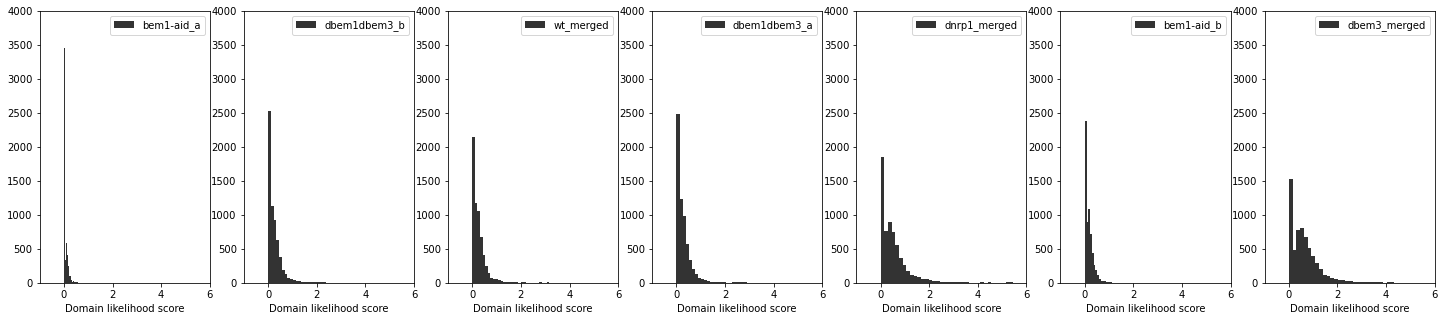

In [121]:
fig, ax = plt.subplots(nrows=1, ncols=len(backgrounds), figsize=(25, 5))
cm = plt.cm.get_cmap('RdYlBu_r')
#color=cm(i/len(backgrounds))
for i in np.arange(0,len(backgrounds)):
    
    ax[i].hist(scores_all_pd.loc[backgrounds[i]]["value"], bins=100, alpha=0.8, label=backgrounds[i], color="black")
    # plt.legend(loc='upper right')
    ax[i].set_xlim([-1,6])
    ax[i].set_ylim([0,4000])
    ax[i].set_xlabel('Domain likelihood score')


    ax[i].legend(loc='upper right')

fig.savefig("../figures/fig_histogram_domain_likelihood_score_per_background.png",dpi=300)

In [122]:
## Matrix where the rows are the unique genes from the scores and the columns are the backgrounds.
# Fill a 1 if that gene has a score=0 in that background, otherwise fill 0. 

all_genes=[]

for key in backgrounds:
    all_genes.append(scores_all_pd.loc[key]["value"].index)

all_genes_array=np.concatenate( all_genes, axis=0)
all_genes_array_unique=np.unique(all_genes_array)

In [198]:
matrix_differential_score=np.ones((len(all_genes_array_unique),len(backgrounds)))
for k in np.arange(0,len(all_genes_array_unique)):
    for i in np.arange(0,len(backgrounds)):
        if all_genes_array_unique[k] in scores_all_pd.loc[backgrounds[i]]["value"].index:
            if scores_all_pd.loc[backgrounds[i],all_genes_array_unique[k] ]["value"]>0.15: # if the score is 0, then the gene is not essential
                matrix_differential_score[k,i]=0


<AxesSubplot:>

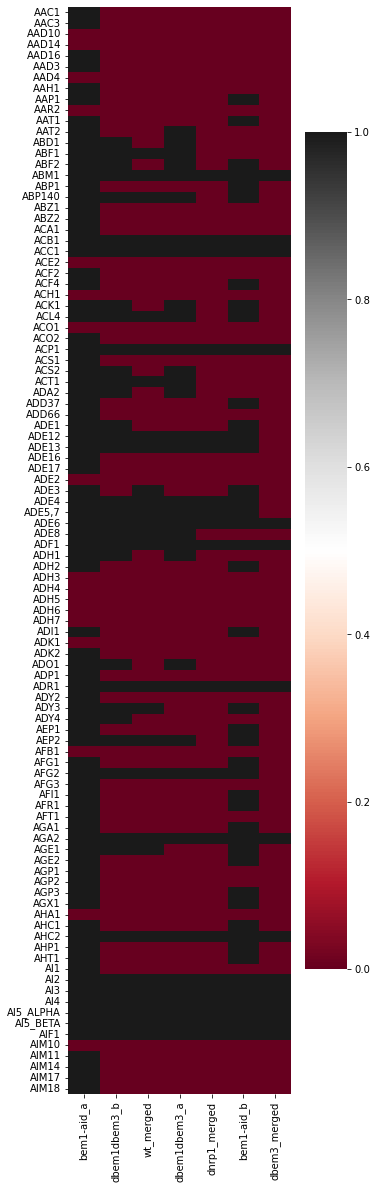

In [199]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 20))
n=100
sns.heatmap(matrix_differential_score[0:n,:], xticklabels=backgrounds, yticklabels=all_genes_array_unique[0:n], cmap="RdGy", vmin=0, vmax=1)

#fig.savefig("../figures/fig_prototype_heatmap_domain_likelihood_score_per_background.png",dpi=300)

([<matplotlib.axis.YTick at 0x7f7a5c152790>,
 [Text(0, 0, 'AAC1'),
  Text(0, 1, 'AAC3'),
  Text(0, 2, 'AAD10'),
  Text(0, 3, 'AAD14'),
  Text(0, 4, 'AAD16'),
  Text(0, 5, 'AAD3'),
  Text(0, 6, 'AAD4'),
  Text(0, 7, 'AAH1'),
  Text(0, 8, 'AAP1'),
  Text(0, 9, 'AAR2'),
  Text(0, 10, 'AAT1'),
  Text(0, 11, 'AAT2'),
  Text(0, 12, 'ABD1'),
  Text(0, 13, 'ABF1'),
  Text(0, 14, 'ABF2'),
  Text(0, 15, 'ABM1'),
  Text(0, 16, 'ABP1'),
  Text(0, 17, 'ABP140'),
  Text(0, 18, 'ABZ1'),
  Text(0, 19, 'ABZ2'),
  Text(0, 20, 'ACA1'),
  Text(0, 21, 'ACB1'),
  Text(0, 22, 'ACC1'),
  Text(0, 23, 'ACE2'),
  Text(0, 24, 'ACF2'),
  Text(0, 25, 'ACF4'),
  Text(0, 26, 'ACH1'),
  Text(0, 27, 'ACK1'),
  Text(0, 28, 'ACL4'),
  Text(0, 29, 'ACO1'),
  Text(0, 30, 'ACO2'),
  Text(0, 31, 'ACP1'),
  Text(0, 32, 'ACS1'),
  Text(0, 33, 'ACS2'),
  Text(0, 34, 'ACT1'),
  Text(0, 35, 'ADA2'),
  Text(0, 36, 'ADD37'),
  Text(0, 37, 'ADD66'),
  Text(0, 38, 'ADE1'),
  Text(0, 39, 'ADE12'),
  Text(0, 40, 'ADE13'),
  Text(0, 41,

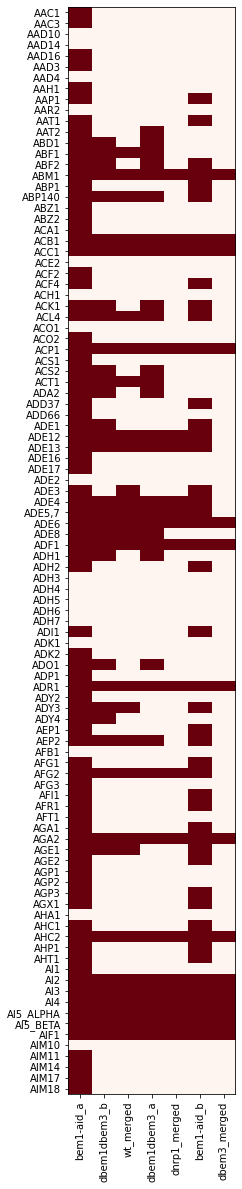

In [200]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3, 20))
plt.imshow(matrix_differential_score[0:n,:], interpolation='nearest', cmap=plt.cm.Reds,aspect='auto')
plt.xticks(range(len(backgrounds)), backgrounds,rotation=90)
plt.yticks(range(n),all_genes_array_unique[0:n])


#fig.savefig("../figures/fig_prototype_heatmap_domain_likelihood_score_per_background_2.png",dpi=300)

In [201]:
goi=["CLA4","BEM2","CDC24","RDI1","CDC10","NRP1","CDC42","MEC1","ACT1"]
tmp=[]
for i in goi:
    tmp.append(np.where(all_genes_array_unique==i)[0][0])

<AxesSubplot:>

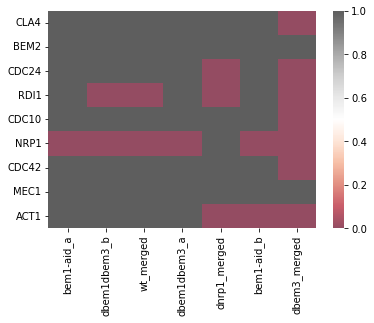

In [204]:
goi_matrix=matrix_differential_score[tmp,:]
sns.heatmap(goi_matrix, xticklabels=backgrounds, yticklabels=goi, cmap="RdGy", vmin=0, vmax=1,alpha=0.7)


In [197]:
scores_all_pd.loc["wt_merged","ACT1"]

value    0.149734
Name: (wt_merged, ACT1), dtype: float64

In [ ]:
## Validate the  predicted scores for WT with the annotated essential genes for WT